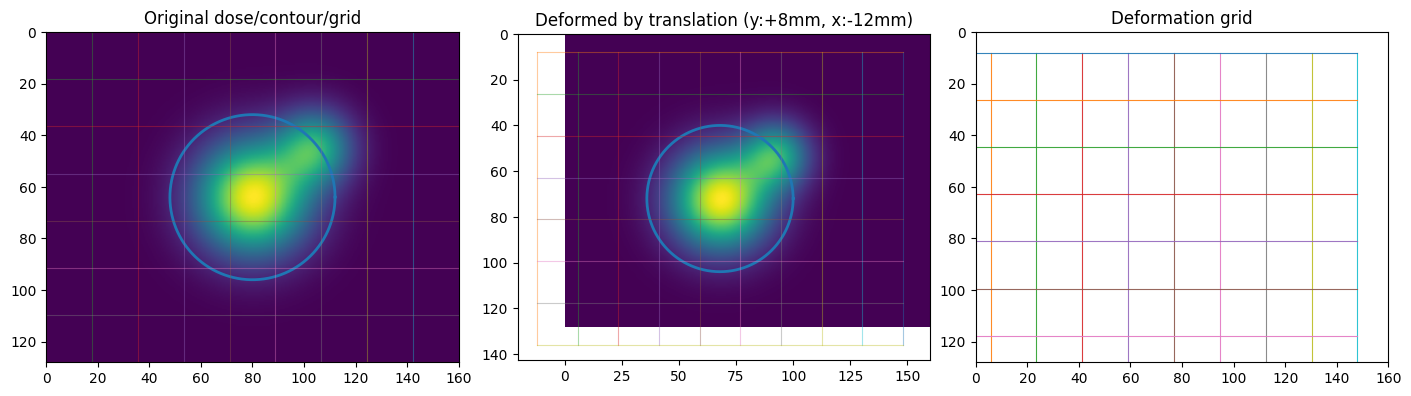

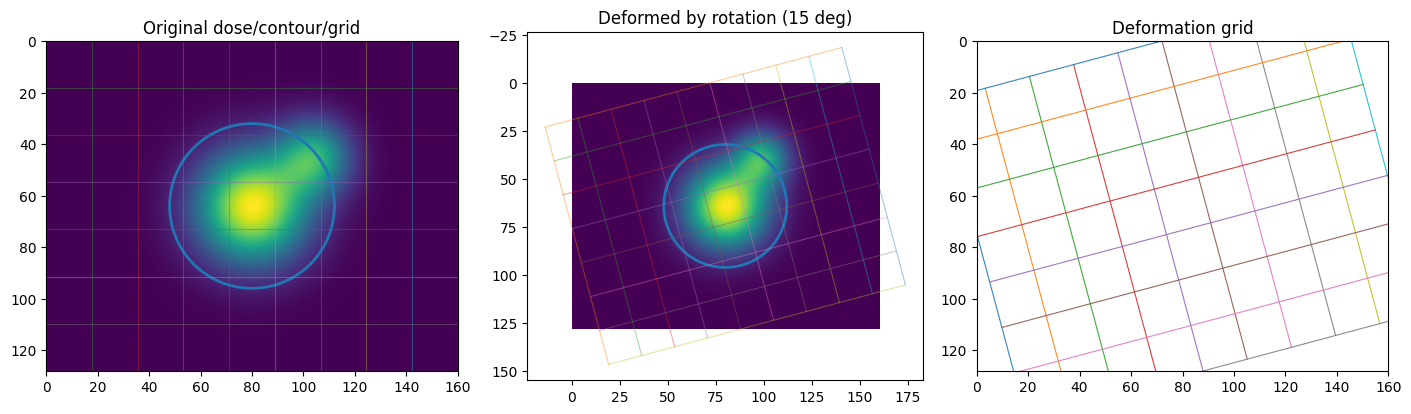

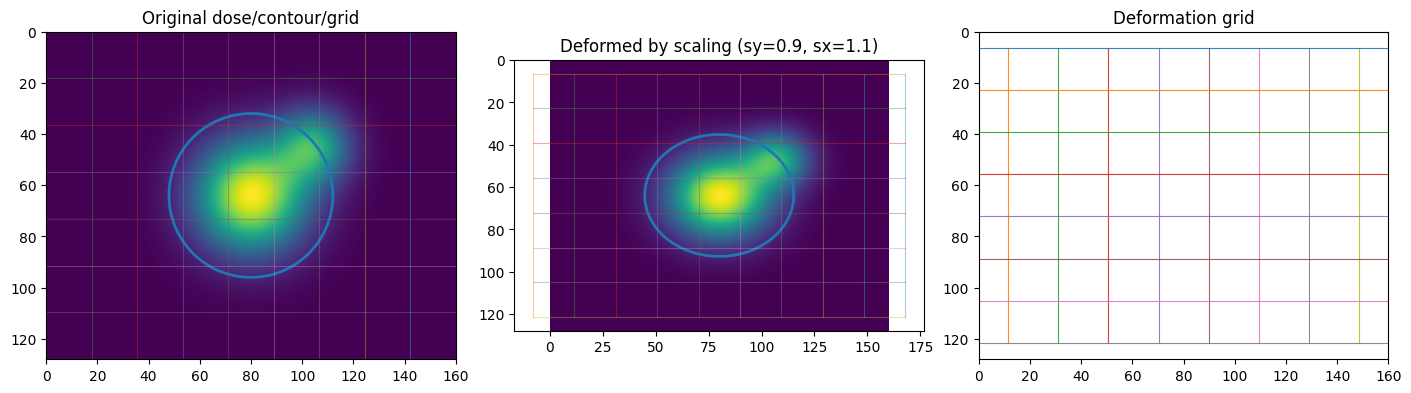

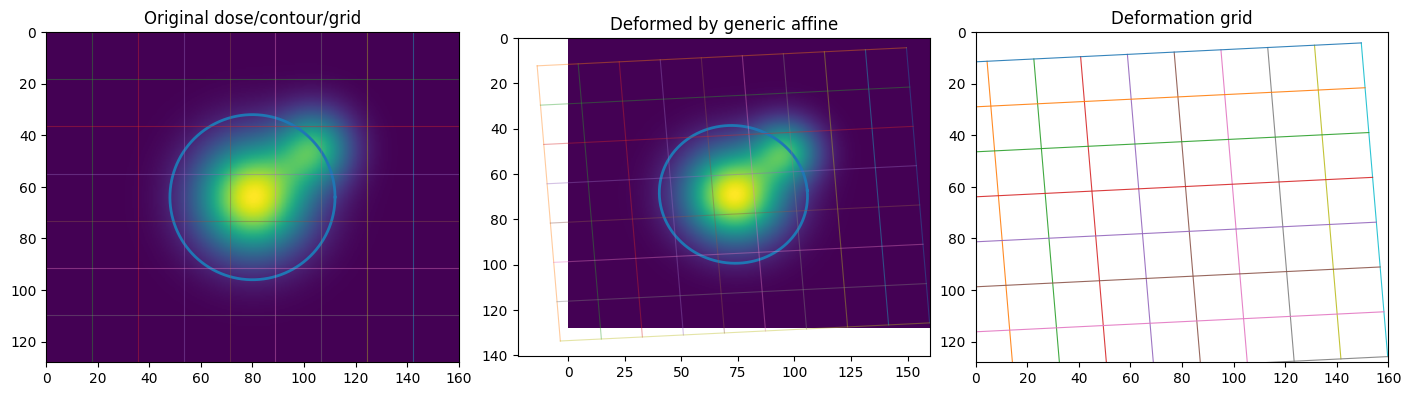

In [1]:
# composable-mapping demo: multi-resolution dose + fine contour, 2D
# Requires: pip install composable-mapping torch matplotlib

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import composable_mapping as cm


# =========================
# Compatibility helpers
# =========================
def cs_grid(cs):
    """Return CoordinateSystem grid as a MappableTensor (handles property/method)."""
    g = getattr(cs, "grid")
    return g() if callable(g) else g

def cs_shape(cs):
    """Return (H, W[, ...]) regardless of property/method API."""
    s = getattr(cs, "spatial_shape")
    return s() if callable(s) else s

def cs_spacing(cs):
    """Return spacing tensor regardless of property/method API or CPU/GPU variant."""
    f = getattr(cs, "grid_spacing", None) or getattr(cs, "grid_spacing_cpu", None)
    if f is None:
        raise AttributeError("CoordinateSystem has no grid_spacing[ _cpu ] accessor")
    return f() if callable(f) else f

def mt_from_tensor(t, n_channel_dims=1):
    """Create a MappableTensor from a tensor, across versions."""
    if hasattr(cm, "mappable"):
        return cm.mappable(t, n_channel_dims=n_channel_dims)
    # Fallback: older/newer API name
    return cm.MappableTensor.from_tensor(t, n_channel_dims=n_channel_dims)

def get_sampler(name="linear"):
    """Version-safe access to samplers."""
    # Directly instantiate the interpolator classes
    return cm.NearestInterpolator() if name == "nearest" else cm.LinearInterpolator()


# =========================
# Coordinate systems & data
# =========================
def make_coordinate_systems(H=128, W=160, img_spacing_mm=1.0, dose_spacing_mm=0.5):
    """
    Two grids with identical physical FOV:
      - image grid: (H, W), spacing = img_spacing_mm
      - dose  grid: (Hd, Wd), spacing = dose_spacing_mm (denser grid)
    Origin = (0,0), orientation = identity (world in mm).
    """
    img_cs = cm.CoordinateSystem.voxel((H, W)).multiply_world(
        torch.tensor([img_spacing_mm, img_spacing_mm], dtype=torch.float32)
    )
    Hd = int(round(H * img_spacing_mm / dose_spacing_mm))
    Wd = int(round(W * img_spacing_mm / dose_spacing_mm))
    dose_cs = cm.CoordinateSystem.voxel((Hd, Wd)).multiply_world(
        torch.tensor([dose_spacing_mm, dose_spacing_mm], dtype=torch.float32)
    )

    # Optional FOV sanity check
    img_fov = torch.tensor([H * img_spacing_mm, W * img_spacing_mm])
    dose_fov = torch.tensor([Hd * dose_spacing_mm, Wd * dose_spacing_mm])
    if not torch.allclose(img_fov, dose_fov, atol=1e-3):
        print(f"[warn] FOV mismatch: img {img_fov.tolist()} mm vs dose {dose_fov.tolist()} mm")

    return img_cs, dose_cs

def make_synthetic_dose(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))
    g2 = 0.6 * torch.exp(-((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2))
    dose = (g1 + g2).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()

def make_circle_contour(center_yx_mm, radius_mm, step_mm=0.1):
    """
    Return Nx2 world coordinates (in mm) for a circle with arc-length spacing ~step_mm.
    center_yx_mm: (y, x) in mm
    """
    circumference = 2.0 * math.pi * radius_mm
    n = max(16, int(round(circumference / step_mm)))
    # Older torch doesn't support endpoint=. Emulate [0, 2π) by dropping last point.
    thetas = torch.linspace(0.0, 2.0 * math.pi, n + 1, dtype=torch.float32)[:-1]
    y = center_yx_mm[0] + radius_mm * torch.sin(thetas)
    x = center_yx_mm[1] + radius_mm * torch.cos(thetas)
    return torch.stack([y, x], dim=-1)  # [N, 2] world coords in mm


# =========================
# Affine mappings in world
# =========================
def affine_about_point(R_2x2, t_2, pivot_yx):
    """
    Build a 3x3 homogeneous transform acting in world (mm) that rotates/scales about pivot.
    x' = T * x_hom, where x=[y,x,1]^T
    R_2x2 acts on [y,x]; t_2 is extra translation (world mm).
    """
    T = torch.eye(3, dtype=torch.float32)
    T[:2, :2] = R_2x2
    T[:2, 2] = t_2
    # Conjugate about pivot
    P = torch.eye(3, dtype=torch.float32);     P[:2, 2] = -pivot_yx
    Pinv = torch.eye(3, dtype=torch.float32);  Pinv[:2, 2] = pivot_yx
    return Pinv @ T @ P  # 3x3

def _wrap_affine_matrix(M):
    """Create cm.Affine from 3x3 matrix and stash matrix for inversion fallback."""
    if hasattr(cm, "Affine") and hasattr(cm.Affine, "from_matrix"):
        m = cm.Affine.from_matrix(M)
    else:
        # Fallback functional API
        m = cm.affine(M)
    # Stash for fallback inverse
    try:
        setattr(m, "_H", M.clone())
    except Exception:
        pass
    return m

def mapping_translation(ty_mm, tx_mm, cs):
    M = torch.eye(3, dtype=torch.float32)
    M[0, 2] = ty_mm
    M[1, 2] = tx_mm
    return _wrap_affine_matrix(M)

def mapping_rotation(angle_deg, cs):
    theta = math.radians(angle_deg)
    R = torch.tensor([[ math.cos(theta), -math.sin(theta)],
                      [ math.sin(theta),  math.cos(theta)]], dtype=torch.float32)
    H, W = cs_shape(cs); sy, sx = cs_spacing(cs)
    pivot = torch.tensor([H * sy / 2.0, W * sx / 2.0], dtype=torch.float32)
    M = affine_about_point(R, torch.tensor([0.0, 0.0]), pivot)
    return _wrap_affine_matrix(M)

def mapping_scaling(sy_scale, sx_scale, cs):
    S = torch.tensor([[sy_scale, 0.0], [0.0, sx_scale]], dtype=torch.float32)
    H, W = cs_shape(cs); sy, sx = cs_spacing(cs)
    pivot = torch.tensor([H * sy / 2.0, W * sx / 2.0], dtype=torch.float32)
    M = affine_about_point(S, torch.tensor([0.0, 0.0]), pivot)
    return _wrap_affine_matrix(M)

def mapping_generic_affine(A_2x2, t_2, cs):
    H, W = cs_shape(cs); sy, sx = cs_spacing(cs)
    pivot = torch.tensor([H * sy / 2.0, W * sx / 2.0], dtype=torch.float32)
    M = affine_about_point(A_2x2, t_2, pivot)
    return _wrap_affine_matrix(M)

def invert_mapping(mapping):
    """Return inverse of a cm.Affine mapping with multiple fallbacks."""
    # Preferred API - use invert() method
    if hasattr(mapping, "invert") and callable(getattr(mapping, "invert")):
        return mapping.invert()
    # Fallback: try other common names
    for name in ("inverse", "inv"):
        if hasattr(mapping, name) and callable(getattr(mapping, name)):
            return getattr(mapping, name)()
    # Matrix fallback
    H = getattr(mapping, "_H", None)
    if H is not None:
        Hinv = torch.linalg.inv(H)
        return _wrap_affine_matrix(Hinv)
    raise RuntimeError("Cannot invert mapping; no API/matrix found.")


# =========================
# Warping & points
# =========================
def warp_dose_to_same_grid(dose_tensor, dose_cs, mapping_fwd, mode="linear"):
    """
    Pull warp: output lives on the *original dose grid*.
    We need the *inverse* mapping for sampling:
        dose_def(y_out) = dose_src( mapping_fwd^{-1}(y_out) )
    """
    sampler = get_sampler("nearest" if mode == "nearest" else "linear")

    # DEBUG FIX:
    # The original dose_tensor has shape [1, 1, H, W], which corresponds to (B, C, H, W).
    # The error occurred because the code passed n_channel_dims=1.
    # The library then interpreted the data as (C, *Spatial), making the
    # spatial_shape (1, H, W), which mismatches the coordinate system's (H, W).
    #
    # The correct fix is to specify n_channel_dims=2, to account for both
    # the Batch and Channel dimensions, leaving (H, W) as the spatial shape.
    vol = cm.SamplableVolume.from_tensor(
        dose_tensor, dose_cs, sampler=sampler, n_channel_dims=2
    )

    tgt_world = cs_grid(dose_cs)          # world coords on the dose grid (so output stays on it)
    inv_map = invert_mapping(mapping_fwd)
    src_world = inv_map(tgt_world)        # where to sample from (backward map)
    warped_mt = vol(src_world)            # MappableTensor of values
    warped = warped_mt.generate_values()  # [1, 1, Hd, Wd]
    
    # The old "if" block for reshaping (from the WIP file) is no longer needed.
    return warped

def deform_points_world(pts_yx, mapping_fwd):
    """
    pts_yx: [N, 2] world mm (y,x). Apply *forward* mapping (push) to points.
    returns: [N, 2]
    """
    pts_ch_sp = pts_yx.T.unsqueeze(0)                # [1, 2, N]
    pts_mt = mt_from_tensor(pts_ch_sp, n_channel_dims=1)
    pts_def = mapping_fwd(pts_mt).generate_values()  # [1, 2, N]
    return pts_def.squeeze(0).T                      # [N, 2]


# =========================
# Visualization
# =========================
def _apply_mapping_points(mapping_fwd, yx_pts):
    """Apply mapping to [N,2] world-mm points robustly."""
    pts = mt_from_tensor(yx_pts.T.unsqueeze(0), n_channel_dims=1)
    out = mapping_fwd(pts).generate_values().squeeze(0).T
    return out

def plot_grid(ax, cs, mapping_fwd=None, every=16, alpha=0.8, lw=0.8):
    """Draw a (possibly) deformed lattice in world mm coordinates."""
    H, W = cs_shape(cs); sy, sx = cs_spacing(cs)
    ny = max(2, H // every)
    nx = max(2, W // every)
    ys = torch.linspace(0, H * sy, ny)
    xs = torch.linspace(0, W * sx, nx)

    # verticals
    for x in xs:
        y = torch.linspace(0, H * sy, 200)
        line = torch.stack([y, torch.full_like(y, x)], dim=-1)   # [N,2]
        if mapping_fwd is not None:
            line = _apply_mapping_points(mapping_fwd, line)
        ax.plot(line[:, 1].numpy(), line[:, 0].numpy(), linewidth=lw, alpha=alpha)

    # horizontals
    for y in ys:
        x = torch.linspace(0, W * sx, 200)
        line = torch.stack([torch.full_like(x, y), x], dim=-1)
        if mapping_fwd is not None:
            line = _apply_mapping_points(mapping_fwd, line)
        ax.plot(line[:, 1].numpy(), line[:, 0].numpy(), linewidth=lw, alpha=alpha)

def show_one(mapping_name, mapping_fwd, img_cs, dose_cs, dose_tensor, contour_world):
    # Dense: backward warp to keep output on original dose grid
    warped = warp_dose_to_same_grid(dose_tensor, dose_cs, mapping_fwd, mode="linear")
    # Sparse: forward transform contour points
    contour_def = deform_points_world(contour_world, mapping_fwd)

    Hy, Wx = cs_shape(dose_cs); sy, sx = cs_spacing(dose_cs)
    ext = [0, Wx * sx, Hy * sy, 0]

    fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

    # original
    axs[0].imshow(dose_tensor[0, 0].numpy().squeeze(), extent=ext)
    axs[0].plot(contour_world[:, 1].numpy(), contour_world[:, 0].numpy(), lw=2)
    plot_grid(axs[0], img_cs, mapping_fwd=None, every=16, alpha=0.4)
    axs[0].set_title("Original dose/contour/grid"); axs[0].set_aspect('equal')

    # deformed
    axs[1].imshow(warped[0, 0].numpy().squeeze(), extent=ext)
    axs[1].plot(contour_def[:, 1].numpy(), contour_def[:, 0].numpy(), lw=2)
    plot_grid(axs[1], img_cs, mapping_fwd=mapping_fwd, every=16, alpha=0.4)
    axs[1].set_title(f"Deformed by {mapping_name}"); axs[1].set_aspect('equal')

    # deformation grid alone
    plot_grid(axs[2], img_cs, mapping_fwd=mapping_fwd, every=16, alpha=0.9)
    axs[2].set_xlim(0, Wx * sx); axs[2].set_ylim(Hy * sy, 0)
    axs[2].set_title("Deformation grid"); axs[2].set_aspect('equal')

    plt.show()


# =========================
# Main demo
# =========================
if __name__ == "__main__":
    torch.set_default_dtype(torch.float32)

    # Base sizes
    H, W = 128, 160
    img_cs, dose_cs = make_coordinate_systems(H, W, img_spacing_mm=1.0, dose_spacing_mm=0.5)

    # Synthetic high-res dose on its own grid (0.5 mm)
    dose = make_synthetic_dose(dose_cs)  # [1,1,Hd,Wd]

    # Fine circle contour (0.1 mm step) in world mm; center is image center (1 mm spacing)
    center_world = torch.tensor([H * 1.0 / 2.0, W * 1.0 / 2.0], dtype=torch.float32)
    contour = make_circle_contour(center_world, radius_mm=min(H, W) * 0.25, step_mm=0.1)

    # Affine mappings (forward, world -> world)
    maps = {
        "translation (y:+8mm, x:-12mm)": mapping_translation(8.0, -12.0, img_cs),
        "rotation (15 deg)":              mapping_rotation(15.0, img_cs),
        "scaling (sy=0.9, sx=1.1)":       mapping_scaling(0.9, 1.1, img_cs),
        "generic affine":                 mapping_generic_affine(
                                              torch.tensor([[0.95, -0.05],
                                                            [0.08,  1.02]], dtype=torch.float32),
                                              torch.tensor([5.0, -7.0], dtype=torch.float32),
                                              img_cs),
    }

    for name, m in maps.items():
        show_one(name, m, img_cs, dose_cs, dose, contour)

In [4]:
# --- 1. Define the Nonlinear Deformation (from quick_start.ipynb) ---
print("Creating nonlinear (deformable) mapping...")

# Get the world coordinates for every voxel in the image coordinate system
# We use 'img_cs' which is already defined from the previous cell.
# --- This line is now corrected ---
V_nl = img_cs.grid_world[None]

# Calculate the norm (radius) for each voxel from the center (0,0)
norm_V_nl = torch.norm(V_nl, dim=-1, keepdim=True)

# Define the properties of the "inward pinch" deformation.
# Note: The radii are in 'mm' to match the 'img_cs' coordinate system,
# unlike the normalized coordinates used in the quick_start notebook.
# These values are chosen to be visible on the demo image.
radius_inner_mm = 15.0
radius_outer_mm = 50.0
strength = 0.5  # This is the same strength as in quick_start

# Calculate the vector field:
# -V_nl makes it point inwards toward the center.
# The boolean logic activates it only between the inner and outer radii.
V_nl = -V_nl * (norm_V_nl > radius_inner_mm) * (norm_V_nl < radius_outer_mm) * strength

# Create the composable mapping object for this dense deformation
nonlinear_deformation = cm.DenseDeformation(V_nl, img_cs)


# --- 2. Create New 'maps' Dictionary with All Deformations ---
# This dictionary includes all the original affine maps plus our new nonlinear one.

print("--- Demonstrating Affine and Nonlinear Deformations ---")

maps_with_nonlinear = {
    "translation (y:+8mm, x:-12mm)": mapping_translation(8.0, -12.0, img_cs),
    "rotation (15 deg)":              mapping_rotation(15.0, img_cs),
    "scaling (sy=0.9, sx=1.1)":       mapping_scaling(0.9, 1.1, img_cs),
    "generic affine":                 mapping_generic_affine(
                                          torch.tensor([[0.95, -0.05],
                                                        [0.08,  1.02]], dtype=torch.float32),
                                          torch.tensor([5.0, -7.0], dtype=torch.float32),
                                          img_cs),
    
    # --- This is the newly added mapping ---
    "nonlinear (inward pinch)":       nonlinear_deformation
}


# --- 3. Run the Visualization Loop ---
# This is the same loop as in the original demo, but it now iterates
# over the new dictionary that includes the nonlinear deformation.

for name, m in maps_with_nonlinear.items():
    show_one(name, m, img_cs, dose_cs, dose, contour)

Creating nonlinear (deformable) mapping...


AttributeError: 'CoordinateSystem' object has no attribute 'grid_world'